In [1]:
import io, math, plantuml, graphviz, os.path
import pandas as pd
import numpy as np
# TODO: импортировать только необходимое
from pyeda.inter import *
from graphviz import Source
from transitions.extensions import GraphMachine
from IPython.display import Image, display

# Теория автоматов
--------------------------------------------------------------------------------

Исследование процесса перевода абстрактного (*АА*) автомата в автомат структурный
(*СА*). Документ основан на [учебном пособии][1] Ожиганова А. А.
"Теория автоматов".

![AbstractAutomat](img/AA.png " Абстрактный Автомат")

Задача создания *СА* сводится к следующим этапам:

* Вычислению функций выходных сигналов $y_n$
* Вычислению функций сигналов возбуждения элементов памяти $U_r$

Все сигналы исходят из комбинационной схемы *КС*. Сигналов возбуждения элементов
памяти связывает *КС* и память *П*.

План документа:

1. Общая теория
2. Описание *АА* Мили с помощью таблиц переходов
3. Реализация модели автомата с помощью библиотеки [transitions][2]
4. Запуск *АА* на заданном входном слове
6. Преобразование *АА* в *СА*  с помощью библиотеки [pyeda][3]
    1. Кодирование входных и выходных сигналов *разрядным* двоичным кодом
    2. Кодировка состояний [*кодом Грея*][4]
    3. Моделирование ячейки памяти автомата
    4. Вычисление таблиц истинности для $y_n$
    5. Нахождение *ДНФ* для $y_n$
    6. Вычисление таблиц истинности для $U_r$
    7. Нахождение *ДНФ* для $U_r$
8. Запуск *СА* на входном слове заданном для *АА*
9. Проверка равенства двух выходных слов

Для удобства входной и выходной алфавиты обоих автоматов кодированы рядом
натуральных чисел $\mathbb{N}$. При этом при создании автоматов их алфавиты
могут быть вполне разнообразными. При кодировке состояний используется код
Грея для минимизации действий необходимых для смены состояния.


[1]: https://books.ifmo.ru/book/826/teoriya_avtomatov._uchebnoe_posobie.htm
[2]: https://github.com/pytransitions/transitions
[3]: https://pyeda.readthedocs.io/en/latest/index.html
[4]: https://ru.wikipedia.org/wiki/Код_Грея

## Общая теория
--------------------------------------------------------------------------------
Напомним, что любой автомат описывается шестикомпонентным набором:

$S = (A, Z, W, \delta, \lambda, a1)$, где

1. $A = {a_1,...,a_m,...,a_M}$ - множество состояний или алфавит состояний *АА*
2. $Z = {z_1,...,z_f,...,z_F}$ - множество входных сигналов или входной алфавит *АА*
3. $W = {w_1,...,w_g,...,w_G}$ - множество выходных сигналов или выходной алфавит *АА*
4. $\delta$ - функция переходов *АА*: $\delta(a_m, z_f) \mapsto a_s\ |\ a_m, a_s \in A$
5. $\lambda$ - функция выходов *АА*: $\lambda(a_m, z_f) \mapsto w_g\ |\ a_m \in A, w_g \in G$
7. $а_1$ - начальное состояние *АА*

## Описание АА
--------------------------------------------------------------------------------

Задаём элементы *АА* $S$:

* Алфавит состояний $A$
* Алфавит событий $Z$
* Алфавит сигналов $W$
* Функцию $\delta$
* Функцию $\lambda$
* Начальное состояние $a_1$

In [2]:
states = ['a1', 'a2', 'a3']             # A
events = ['z1', 'z2', 'z3']             # Z
signls = ['w1', 'w2', 'w3', 'w4', 'w5'] # W
initial = 'a1'                          # a1

In [3]:
delta = np.array(           # delta
    [['a2', '', 'a1'],
     ['a3', 'a1', ''],
     ['a2', 'a3', 'a3']])
lmbda = np.array(           # lambda
    [['w1', '', 'w2'],
     ['w4', 'w5', ''],
     ['w2', 'w1', 'w3']])

In [4]:
deltaFr = pd.DataFrame(
    delta,
    columns=states,
    index=events)
deltaFr

,a1,a2,a3
z1,a2,,a1
z2,a3,a1,
z3,a2,a3,a3


In [5]:
lmbdaFr = pd.DataFrame(
    lmbda,
    columns=states,
    index=events)
lmbdaFr

,a1,a2,a3
z1,w1,,w2
z2,w4,w5,
z3,w2,w1,w3


## Реализация модели автомата

In [6]:
class Automat():    
    def __init__(self):
        self.inputDict = {}  # Z
        self.outputDict = {} # W
        self.input = []
        self.output = []
        # Для удобства логика конструктора вынесена вовне

    def process(self):
        self.output = []
        for inpSigNum in model.input:
            inpSigStr = str(inpSigNum)
            inpSig = self.inputDict[inpSigStr]
            event = getattr(self, inpSig)
            event()
    
    def show_graph(self, **kwargs):        
        stream = io.BytesIO()
        self.get_graph(**kwargs).draw(stream, prog='dot', format='png')
        display(Image(stream.getvalue()))

In [7]:
model = Automat()
machine = GraphMachine(
    model=model,
    states=states, 
    initial=initial)

In [8]:
desc = np.dstack((delta, lmbda))
print(desc.shape)
desc

(3, 3, 2)


array([[['a2', 'w1'],
        ['', ''],
        ['a1', 'w2']],

       [['a3', 'w4'],
        ['a1', 'w5'],
        ['', '']],

       [['a2', 'w2'],
        ['a3', 'w1'],
        ['a3', 'w3']]], dtype='<U2')

In [9]:
outputDict = {} # W
mappings = []

def decode(model, outSig):
    letter = model.outputDict[outSig]
    model.output.append(letter)

for z in range(len(events)):
    inpSig = events[z]
    for a in range(len(states)):
        fromState = states[a]
        toState = desc[z, a, 0]
        outSig = desc[z, a, 1]
        if not toState: continue

        mappings.append([inpSig, fromState, toState, outSig])
        machine.add_transition(
            inpSig,
            fromState,
            toState,
            after = lambda outSig=outSig: decode(model, outSig))

mappings

[['z1', 'a1', 'a2', 'w1'],
 ['z1', 'a3', 'a1', 'w2'],
 ['z2', 'a1', 'a3', 'w4'],
 ['z2', 'a2', 'a1', 'w5'],
 ['z3', 'a1', 'a2', 'w2'],
 ['z3', 'a2', 'a3', 'w1'],
 ['z3', 'a3', 'a3', 'w3']]

In [10]:
def makeSignalDict(alphabet, dirStrict=True):
    sigDict = {}
    for z in range(len(alphabet)):
        num = str(z + 1)
        sig = alphabet[z]
        if dirStrict:
            sigDict[sig] = num
        else:
            sigDict[num] = sig
    return sigDict

In [11]:
inputDict = makeSignalDict(events, False)  # Z
model.inputDict = inputDict
inputDict

{'1': 'z1', '2': 'z2', '3': 'z3'}

In [12]:
outputDict = makeSignalDict(signls)  # W
model.outputDict = outputDict
outputDict

{'w1': '1', 'w2': '2', 'w3': '3', 'w4': '4', 'w5': '5'}

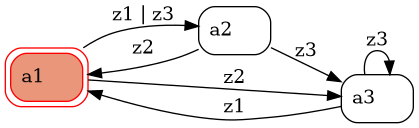

In [13]:
model.show_graph()

In [14]:
model.z2()
model.state

'a3'

In [15]:
model.z1()
model.state

'a1'

## Запуск АА на заданном входном слове

In [16]:
model.input = [2, 1, 3, 2, 1, 3, 3, 3, 1]
model.process()
model.state

'a1'

In [17]:
# Avstract Automat Input Output
AAIO = np.array([model.input, model.output])
AAIO

array([['2', '1', '3', '2', '1', '3', '3', '3', '1'],
       ['4', '2', '2', '5', '1', '1', '3', '3', '2']], dtype='<U21')

## Преобразование АА в СА

### Кодирование входных, выходных сигналов и состояний
--------------------------------------------------------------------------------

Каждому из следующих множеств (компонентов) нашего *АА* ставится в соответствие
некий двоичный вектор.

Входные сигналы $Z$:

$$
z_f \mapsto (e_{f1},...,e_{fl},...,e_{fL})\ | \ e_{fl} \in \{0, 1\},
z \in Z, L = \lceil log_2F \rceil, F=|Z|
$$

Выходные сигналы $W$:

$$
w_g \mapsto (e_{g1},...,e_{gn},...,e_{gN})\ | \ e_{gn} \in \{0, 1\},
w \in W, N = \lceil log_2G \rceil, G=|W|
$$

Состояния $A$:

$$
a_m \mapsto (e_{m1},...,e_{mr},...,e_{mR})\ | \ e_{mr} \in \{0, 1\},
a \in A, R = \lceil log_2M \rceil, M=|A|
$$

Запись $\lceil x \rceil$ означает *потолок* (`ceil`) - ближайшее целое число
большее или равно $x$.

--------------------------------------------------------------------------------
Для кодирования входных и выходных сигналов можно использовать обычный
*разрядовый* двоичный код и [*кода Грея*][2]. При *разрядовом* двоичном
кодировании соседние значения могут отличаться более чем на бит:

$$
\begin{array}{c}
    0000\\
    0001\\
    0010\\
    0011\\
    0100\\
    ...
\end{array} 
$$

К примеру разница между числом $01_{b}$ и $10_{b}$ два бита - младший и старший.
Данная разница описывается термином [*расстояние Хэмминга*][1]:

$$
d_{ij} = \sum_{k=1}^{p} |x_{ik}-x_{jk}|
$$

Соответственно при использовании *разрядового* кодирования в физической среде
электрических сигналов растёт риск помех. Так же растёт сложность механизмов
участвующих в кодировке и раскодировке этих сигналов. Несмотря на это
предполагается, что *внешняя среда* относительно нашего *СА* достаточно развитая
для такого взаимодействия. Так же возникает необходимость следовать стандартным
интерфейсам. Следовательно входной и выходной алфавиты кодируются именно
*разрядным* образом.

Но переход между состояниями во *внутренней среде* нашего автомата лучше всего
совершать с помощью *кода Грея*. В этом случае соседствующие значения всегда
отличаются на один бит:

$$
\begin{array}{c}
    0000\\
    0001\\
    0011\\
    0010\\
    0110\\
    ...
\end{array} 
$$

Для перехода из *разрядного* в *код Грея* используется следующая формула, где
$i$ это позиция бита:

$$
G_{i} = B_{i} \oplus B_{i+1}
$$

--------------------------------------------------------------------------------
Так же важно заметить следующее. При кодировке выходных сигналов, автор, в своём
труде, сдвигает значения на единицу вверх отображая значения сигналов из
алфавита $W$ в ряд натуральных чисел $\mathbb{N}$. Это делается для того, чтобы
зарезервировать значение $000$ для случая отсутствия сигнала:

$$
f : W \mapsto \mathbb{N}
$$

[1]: https://ru.wikipedia.org/wiki/Расстояние_Хэмминга
[2]: https://ru.wikipedia.org/wiki/Код_Грея

In [18]:
def calcBinArrLen(x):
    return math.ceil(math.log2(x))

In [19]:
def buildColumns(vectorLen, prefix):
    return [prefix + str(x + 1) for x in range(vectorLen)]

In [20]:
def encodeSignals(abcLength, addOne=False, gray=False):
    vectorLength = calcBinArrLen(abcLength)
    signalsBin = np.zeros(
        [abcLength, vectorLength],
        dtype = np.dtype(bool))
    for i in range(abcLength):
        for n in range(vectorLength):
            inputSignal = i
            if addOne:
                inputSignal = inputSignal + 1
            if gray:
                inputSignal = inputSignal ^ (inputSignal >> 1)
            bit = inputSignal & (0x1 << (vectorLength - 1 - n))
            bit = True if bit else False
            signalsBin[i][n] = bit
    return signalsBin

In [21]:
functions = {
    'A': delta,
    'W': lmbda
}

alphabets = {
    'Z': events,
    'W': signls,
    'A': states
}

abcLengths = {
    'Z': len(alphabets['Z']),
    'W': len(alphabets['W']),
    'A': len(alphabets['A'])
}

# Создаём массив закодированных векторов входного и выходного алфавитов, а так же алфавита состояний
vectors = {
    'Z': encodeSignals(abcLengths['Z']),
    'W': encodeSignals(abcLengths['W'], addOne=True),
    'A': encodeSignals(abcLengths['A'], gray=True)
}

vecLengths = {
    'Z': vectors['Z'].shape[1],
    'W': vectors['W'].shape[1],
    'A': vectors['A'].shape[1]
}

contactNames = {
    'Z': buildColumns(vecLengths['Z'], 'x'),
    'W': buildColumns(vecLengths['W'], 'y'),
    'A': buildColumns(vecLengths['A'], 'Q')
}

In [22]:
def makeVectorFrame(letter):
    return pd.DataFrame(
        vectors[letter],
        columns=contactNames[letter],
        index=alphabets[letter])

In [23]:
makeVectorFrame('Z')

,x1,x2
z1,False,False
z2,False,True
z3,True,False


In [24]:
makeVectorFrame('W')

,y1,y2,y3
w1,False,False,True
w2,False,True,False
w3,False,True,True
w4,True,False,False
w5,True,False,True


In [25]:
makeVectorFrame('A')

,Q1,Q2
a1,False,False
a2,False,True
a3,True,True


### Канонический метод структурного синтеза

--------------------------------------------------------------------------------
При каноническом (стандартном) методе структурного синтеза автомат представляют
в виде двух частей: памяти (П) и комбинационной схемы (КС). КС состоит из
логических элементов, а память из автоматов памяти. Элементарными автоматами
памяти являются триггерные схемы.

![ConceptualScheme](img/CS.png "Концептуальная схема")

**Теорема о структурной полноте**

> Любая система элементарных автоматов, содержащая автомат Мура
> (обладающий полнотой переходов и полнотой выходов) и какую-либо функционально
> полную систему логических элементов, является структурно полной

$$
\forall (a_i, a_j) \in A\ \exists z_k \in Z\ |\ \delta (z_k, a_i) \mapsto a_j
$$

Задача синтеза автомата сводится к нахождению функций:

$$
U_r = U_r(Q_1,..., Q_R, x_1,..., x_L), r = 1,..., R
$$

$$
y_n = y_n(Q_1,..., Q_R, x_1,..., x_L), n = 1,..., N
$$

### Моделирование ячейки памяти

--------------------------------------------------------------------------------
Далее вариант триггера в модели абстрактного автомата. $b_{1,2}$ это состояния
ячеёки памяти, а $q_{1,2}$ это входные сигналы автомата.

Сигнал $q_1$ скорее всего лишний в перспективе *АА*, но необходим для его
перевода в *СА*. Это происходит за счёт того, что мы кодируем $q_1$ и $q_2$ в
$0$ и $1$ соответственно. Как известно на уровне *КС* в каждой точке схемы
должен присутствовать какой то сигнал: $0$ или $1$. Соответственно нам неизбежно
необходим $q_1$. Модель ниже реализует принцип `T` триггера работающего по
следующему закону:

$$
Q^{t+1}=Q^t \oplus T
$$

In [26]:
pd.DataFrame(
    [['b1', 'b2'], ['b2', 'b1']],
    columns=['b1', 'b2'],
    index=['q1', 'q2'])

,b1,b2
q1,b1,b2
q2,b2,b1


--------------------------------------------------------------------------------
Необходимо перейти к СА. Для этого закодируем входные и выходные состояния
автомата

In [27]:
pd.DataFrame(
    [[False], [True]],
    columns=['U'],
    index=['q1', 'q2'])

,U
q1,False
q2,True


In [28]:
pd.DataFrame(
    [[False], [True]],
    columns=['Q'],
    index=['b1', 'b2'])

,Q
b1,False
b2,True


--------------------------------------------------------------------------------
На основании предыдущих таблиц строим структурную таблицу, описывающую
функционирование автомата памяти. С этого этапа переводим логические значения в
целочисленные. По оси абсцисс у нас располагаются выходные значения массива
триггеров, а по оси ординат входные.

In [29]:
functionT = np.array([[0, 1], [1, 0]], dtype=int)

In [30]:
pd.DataFrame(
    functionT,
    columns=[0, 1],
    index=[0, 1])

,0,1
0,0,1
1,1,0


### Кодируем таблицы переходов

* $Q_1Q_2$ представляют состояние $a_m$
* $x_1x_2$ представляют входной сигнал $z_f$
* $y_1y_2y_3$ представляют выходной сигнал $w_g$

Таки образом получаем функции переходов следующего вида:

* $y_1y_2y_3 = \lambda (Q_1, Q_2, x_1, x_2)$
* $Q_1Q_2 = \delta (Q_1, Q_2, x_1, x_2)$

In [31]:
# Исконная таблица переходов
deltaFr

,a1,a2,a3
z1,a2,,a1
z2,a3,a1,
z3,a2,a3,a3


In [32]:
def makeTensor(fn, x, vectorX):
    rows = fn.shape[0]
    cols = fn.shape[1]
    levs = vectorX.shape[1]

    arrBinShape = (rows, cols, levs)
    arrBin = np.zeros(arrBinShape, dtype=int)

    for i in range(rows):
        for j in range(cols):
            y = fn[i][j]
            if y:
                xInx = x.index(y)
                xBin = vectorX[xInx]
                arrBin[i][j] = xBin.astype(int)
            else:
                arrBin[i][j] = np.empty((levs,))
                arrBin[i][j][:] = -1
    return arrBin

In [33]:
def makeVectorBin(letter):
    fn = functions[letter]
    x = alphabets[letter]
    vectorX = vectors[letter]
    return makeTensor(fn, x, vectorX)

In [34]:
functionsBin = {
    'A': makeVectorBin('A'),
    'W': makeVectorBin('W')
}

In [35]:
def binToStr(arr):
    #print(arr)
    strVal = ''
    for x in arr:
        strVal = strVal + str(int(x))
    #print(strVal)
    return strVal

def binToStrVec(arr):
    vecStr = []
    for row in arr:
        arrStr = binToStr(row)
        vecStr.append(arrStr)
    return vecStr

def makeVectorBinFrame(fn, xAxis, yAsix):
    vecBinArr = []

    rows = fn.shape[0]
    cols = fn.shape[1]
    
    for i in range(rows):
        vecBinRow = []
        for j in range(cols):
            intArr = fn[i][j];
            if (intArr[0] != -1):
                toStr = binToStr(intArr)
                vecBinRow.append(toStr)
            else:
                vecBinRow.append('')
        vecBinArr.append(vecBinRow)

    return pd.DataFrame(
        vecBinArr,
        columns=binToStrVec(xAxis),
        index=binToStrVec(yAsix))

In [36]:
deltaFr

,a1,a2,a3
z1,a2,,a1
z2,a3,a1,
z3,a2,a3,a3


In [37]:
deltaBinFr = makeVectorBinFrame(
    functionsBin['A'],
    vectors['A'],
    vectors['Z'])
deltaBinFr

,00,01,11
00,01,,00
01,11,00,
10,01,11,11


In [38]:
lmbdaFr

,a1,a2,a3
z1,w1,,w2
z2,w4,w5,
z3,w2,w1,w3


In [39]:
lmbdaBinFr = makeVectorBinFrame(
    functionsBin['W'],
    vectors['A'],
    vectors['Z'])
lmbdaBinFr

,00,01,11
00,001,,010
01,100,101,
10,010,001,011


### Вычисление таблиц истинности выходов КС

--------------------------------------------------------------------------------
Вычисляем функцию $\lambda$:

$$
y_1y_2y_3 = \lambda (Q_1, Q_2, x_1, x_2)
$$

Для построения таблицы истинности, нам нужно преобразовать таблицу функции
$\lambda$ в таблицу истинности непрерывной возрастающей вариации значений
переменных $Q_1, Q_1, x_1, x_2$. Учитывая, что $Q_1$ и $Q_1$ закодированы
*кодом Грея*, нам необходимо восполнить отсутствующие *разрядные* значения.

Имея двумерный вектор булевых значений, нам нужно перевести последнюю строку
$S \in \mathbb{B}$ в целочисленное значение $n$. Перевод осуществляется по формуле:

$$
n = \sum_{i=0}^{|S|} 2^i S_i
$$

In [40]:
last = vectors['A'][-1] # S

i = 0                   # i
lastIntVal = 0          # n
for base in last:
    multiplier = int(math.pow(2, i))
    lastIntVal = lastIntVal + base * multiplier
    i = i + 1
vectorAFull = encodeSignals(lastIntVal + 1)
vectorAFull

array([[False, False],
       [False,  True],
       [ True, False],
       [ True,  True]])

In [41]:
def expandFunctionTable(fnOld, fnNew):   
    idxFull = 0 # Индекс столбца полного вектора состояний
    idxOrig = 0 # Индекс оригинального столбца вектора состояний
    for colFull in vectorAFull:
        colOrig = vectors['A'][idxOrig]
        if (colFull == colOrig).all():
            fnNew[:,idxFull] = fnOld[:,idxOrig]
            idxOrig = idxOrig + 1
        else:
            fnNew[:,idxFull] = -1
        idxFull = idxFull + 1

In [42]:
# Строки: количество входных сигналов
x = vectors['Z'].shape[0]
# Столбцы: интервал бинарных вариаций включающий в себя закодированные состояния
y = vectorAFull.shape[0]
# Слои: количество бит необходимое для отображения выходного сигнала
z = vectors['W'].shape[1]
functionWBinFull = np.zeros((x, y, z), dtype=int)
functionWBin = functionsBin['W'] # Для удобства

In [43]:
expandFunctionTable(functionWBin, functionWBinFull)

In [44]:
lmbdaBinFullFr = makeVectorBinFrame(
    functionWBinFull,
    vectorAFull,
    vectors['Z'])
lmbdaBinFullFr

,00,01,10,11
00,001,,,010
01,100,101,,
10,010,001,,011


#### Вычисление вектора значений

--------------------------------------------------------------------------------
Для использования функции `truthtable` нам необходимо передать строку
истинности. Эта строка должна быть отображением ряда двоичных числел от $0_b$ до
числа $n$, где $n$ максимальное значение заданной длины:

$$
n = 2^{N + R}\ |\ N=\lceil log_2|Z|, R=\rceil + \lceil log_2|A| \rceil
$$

Трёхмерный массив, который мы получили выше даёт срез, который может не равнятся
$n$. Для этого, нам нужно дополнить его нулями.

In [92]:
def makeTruethVector(fn):
    truethTables = []
    
    x = fn.shape[0]
    y = fn.shape[1]
    z = fn.shape[2]

    ttCols = vecLengths['Z'] + vecLengths['A']
    currentLength = x * y
    ttRows = int(math.pow(2, ttCols))
    needAppend = ttRows - currentLength  
    assert(needAppend > 0)
    
    for i in range(z):
        arr = fn[:,:,i]
        arr = arr.reshape((currentLength,))
        ttStr = ''
        for n in arr:
            if n == 1:
                ttStr = ttStr + '1'
            else:
                ttStr = ttStr + '0'
        if needAppend:
            for i in range(needAppend):
                ttStr = ttStr + '0'
        truethTables.append(ttStr)
    return truethTables

In [93]:
yTruethTables = makeTruethVector(functionWBinFull)
yTruethTables

['0000110000000000', '0001000010010000', '1000010001010000']

### Строим ДНФ функции выходов КС

--------------------------------------------------------------------------------

Создадим выражение `pyeda` для аргументов функции:

$$
y_1y_2y_3 = \lambda(Q_1,Q_2,x_1,x_2)
$$

Важно учитывать, что в труде автора индексация бинарных элементов идёт слева
направо, тогда как в коде программы, индексация обычно идёт в обратном порядке.
Для наглядности расчитаем таблицу истинности для $y_1$. Затем расчитаем таблицу
истинности и вычислим *ДНФ* для остальных элементов картежа.

In [116]:
varsALen = vecLengths['A']
varsZLen = vecLengths['A']
assert(varsALen > 1)
assert(varsZLen > 1)
print(varsALen, varsZLen)

2 2


In [117]:
Q1Q2 = exprvars('Q', (1, varsALen + 1))
Q1Q2

farray([Q[1], Q[2]])

In [118]:
x1x2 = exprvars('x', (1, varsZLen + 1))
x1x2

farray([x[1], x[2]])

In [119]:
Q1Q2 + x1x2

farray([Q[1], Q[2], x[1], x[2]])

In [120]:
ttStry1 = yTruethTables[0]
y1 = truthtable(Q1Q2 + x1x2, ttStry1)
y1

x[2] x[1] Q[2] Q[1]
   0    0    0    0 : 0
   0    0    0    1 : 0
   0    0    1    0 : 0
   0    0    1    1 : 0
   0    1    0    0 : 1
   0    1    0    1 : 1
   0    1    1    0 : 0
   0    1    1    1 : 0
   1    0    0    0 : 0
   1    0    0    1 : 0
   1    0    1    0 : 0
   1    0    1    1 : 0
   1    1    0    0 : 0
   1    1    0    1 : 0
   1    1    1    0 : 0
   1    1    1    1 : 0

In [121]:
y1Expr = truthtable2expr(y1)
y1Expr

Or(And(x[1], ~x[2], ~Q[1], ~Q[2]), And(x[1], ~x[2], Q[1], ~Q[2]))

In [122]:
y1bdd = expr2bdd(y1Expr)

In [123]:
imgaesDir = 'img'
imageName = 'graphviz_y1'
imageFormat = 'svg'
fileName = '{0}.{1}'.format(imageName, imageFormat)
filePath = os.path.join(imgaesDir, fileName)
# Удалите файл если необходимо его пересоздать
if not os.path.isfile(filePath):
    from graphviz import Source
    gv = Source(y1bdd.to_dot())
    gv.render(imageName, directory=imgaesDir, cleanup=True, format=imageFormat)

![BDE](img/graphviz_y1.svg "Диаграмма решений")

In [125]:
fArr = []
for ttStr in yTruethTables:
    tt = truthtable(Q1Q2 + x1x2, ttStr)
    fy = truthtable2expr(tt)
    fArr.append(fy)
Y = farray(fArr)
Y

farray([Or(And(x[1], ~x[2], ~Q[1], ~Q[2]), And(x[1], ~x[2], Q[1], ~Q[2])), Or(And(~x[1], ~x[2], Q[1], Q[2]), And(~x[1], x[2], ~Q[1], ~Q[2]), And(~x[1], x[2], Q[1], Q[2])), Or(And(~x[1], ~x[2], ~Q[1], ~Q[2]), And(x[1], ~x[2], Q[1], ~Q[2]), And(~x[1], x[2], Q[1], ~Q[2]), And(~x[1], x[2], Q[1], Q[2]))])

### Вычисление таблиц истинности функции входов памяти

--------------------------------------------------------------------------------
Вычисляем функцию $\delta$:

$$
Q_1Q_2 = \delta (Q_1, Q_2, x_1, x_2)
$$

В данной функции, целесообразно подменить переменные значения на $T_1T_2$, где
$T_i$ это элементы нового состояния системы, а $Q_i$ - элементы предыдущего
состояния. 

$$
T_1T_2 = \delta (Q_1, Q_2, x_1, x_2)
$$

Автор оригинального труда использовал *T* триггер, таблицу истинности которого
преведена выше. Нам будет необходимо составить таблицу входных сигналов памяти
$T_i$ в зависимости от предыдущего состояния памяти $Q_i$ и таблицы истинности
*T* триггера. При этом на этом шаге мы не обращаем внимание на входные сигналы
*КС* $X_i$. На интересуют лишь старое и новое состояния памяти. Далее, как это
было проделано для функции выходов *КС* ($\lambda$), расширить таблицу функции
памяти ($\delta$) для интеграции в интервал входных бинарных значений. На
последнем этапе нам нужно будет составить *ДНФ* для $T_i$ и тут уже мы
подключаем входные сигналы *КС* $X_i$. Итак, нам необходимо проделать следующие
шаги:

1. Составить соответствующую таблицу входных сигналов памяти
2. Расширить таблицу функции памяти ($\delta$)
3. Составить *ДНФ* для $T_i$


#### Кодируем таблицу состояний памяти под входные сигналы
--------------------------------------------------------------------------------
К примеру, проверяем какой должен быть ввод, для того, чтобы перейти из
состояния $1$ в состояни $0$

In [126]:
pd.DataFrame(
    functionT,
    columns=[0, 1],
    index=[0, 1])

,0,1
0,0,1
1,1,0


In [127]:
deltaBinFr

,00,01,11
00,01,,00
01,11,00,
10,01,11,11


In [128]:
np.where(functionT[:,1] == 0)[0][0]

1

In [129]:
functionsBin['T'] = np.zeros(functionsBin['A'].shape, dtype=int)
functionTBin = functionsBin['T']
functionABin = functionsBin['A']
vectorA = vectors['A']
vectorZ = vectors['Z']

In [130]:
vectorA[1,1]

True

In [131]:
x = vectorZ.shape[0]
y = vectorA.shape[0]
z = vectorA.shape[1]

for i in range(x):
    for j in range(y):
        for k in range(z):
            aNew = functionABin[i, j, k]
            if aNew == -1:
                aNew = 2
                aOld = 2
                t = 2
            else:
                aOld = int(vectorA[j, k])
                t = np.where(functionT[:,aNew] == aOld)[0][0]
            # Для отладки
            #print(i, j, k, aOld, aNew, t)
            t = -1 if t == 2 else t
            functionTBin[i, j, k] = t

In [132]:
deltaTBinFr = makeVectorBinFrame(
    functionTBin,
    vectorA,
    vectors['Z'])
deltaTBinFr

,00,01,11
00,01,,11
01,11,01,
10,01,10,00


In [133]:
# Строки: количество входных сигналов
x = vectors['Z'].shape[0]
# Столбцы: интервал бинарных вариаций включающий в себя закодированные состояния
y = vectorAFull.shape[0]
# Слои: количество бит необходимое для отображения выходного сигнала
z = vectors['A'].shape[1]
functionTBinFull = np.zeros((x, y, z), dtype=int)

In [134]:
expandFunctionTable(functionTBin, functionTBinFull)

In [135]:
deltaTBinFullFr = makeVectorBinFrame(
    functionTBinFull,
    vectorAFull,
    vectors['Z'])
deltaTBinFullFr

,00,01,10,11
00,01,,,11
01,11,01,,
10,01,10,,00


#### Вычисление вектора значений

--------------------------------------------------------------------------------

In [136]:
TTruethTables = makeTruethVector(functionTBinFull)
TTruethTables

['0001100001000000', '1001110010000000']

### Строим ДНФ функции ячеек памяти
--------------------------------------------------------------------------------
Создадим выражение `pyeda` для аргументов функции:

$$
T_1T_2 = \delta (Q_1, Q_2, x_1, x_2)
$$

Далее для наглядности расчитаем таблицу истинности для $T_1$. Затем расчитаем
таблицу истинности и вычислим *ДНФ* для остальных элементов картежа.

In [137]:
ttStrT1 = TTruethTables[0]
T1 = truthtable(Q1Q2 + x1x2, ttStrT1)
T1

x[2] x[1] Q[2] Q[1]
   0    0    0    0 : 0
   0    0    0    1 : 0
   0    0    1    0 : 0
   0    0    1    1 : 1
   0    1    0    0 : 1
   0    1    0    1 : 0
   0    1    1    0 : 0
   0    1    1    1 : 0
   1    0    0    0 : 0
   1    0    0    1 : 1
   1    0    1    0 : 0
   1    0    1    1 : 0
   1    1    0    0 : 0
   1    1    0    1 : 0
   1    1    1    0 : 0
   1    1    1    1 : 0

In [138]:
T1Expr = truthtable2expr(T1)
T1Expr

Or(And(~x[1], ~x[2], Q[1], Q[2]), And(x[1], ~x[2], ~Q[1], ~Q[2]), And(~x[1], x[2], Q[1], ~Q[2]))